In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [22]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


In [7]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

data preprocessing


In [9]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [10]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model=VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))
base_model.trainable =False

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
#from tenserflow.keras import layers,models

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(50,activation='relu'),
    layers.Dense(20,activation='relu'),
    layers.Dense(3,activation='softmax')
])

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01,patience = 5,verbose = 1)

model_cp = ModelCheckpoint(filepath="best_model.h5",monitor = "val_accuracy", save_best_only = True, verbose = 1)

In [16]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es,model_cp]

)

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 0.5895 - accuracy: 0.7899
Epoch 1: val_accuracy improved from -inf to 0.82812, saving model to best_model.h5
54/54 [==============================] - 260s 5s/step - loss: 0.5895 - accuracy: 0.7899 - val_loss: 0.4739 - val_accuracy: 0.8281
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9236
Epoch 2: val_accuracy improved from 0.82812 to 0.83854, saving model to best_model.h5
54/54 [==============================] - 259s 5s/step - loss: 0.2197 - accuracy: 0.9236 - val_loss: 0.3731 - val_accuracy: 0.8385
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9485
Epoch 3: val_accuracy improved from 0.83854 to 0.86458, saving model to best_model.h5
54/54 [==============================] - 266s 5s/step - loss: 0.1498 - accuracy: 0.9485 - val_loss: 0.3865 - val_accuracy: 0.8646
Epoch 4/10
54/54 [==============================] - ETA: 0s - loss: 0.185

In [17]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 27s 3s/step - loss: 0.3389 - accuracy: 0.8750


In [18]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

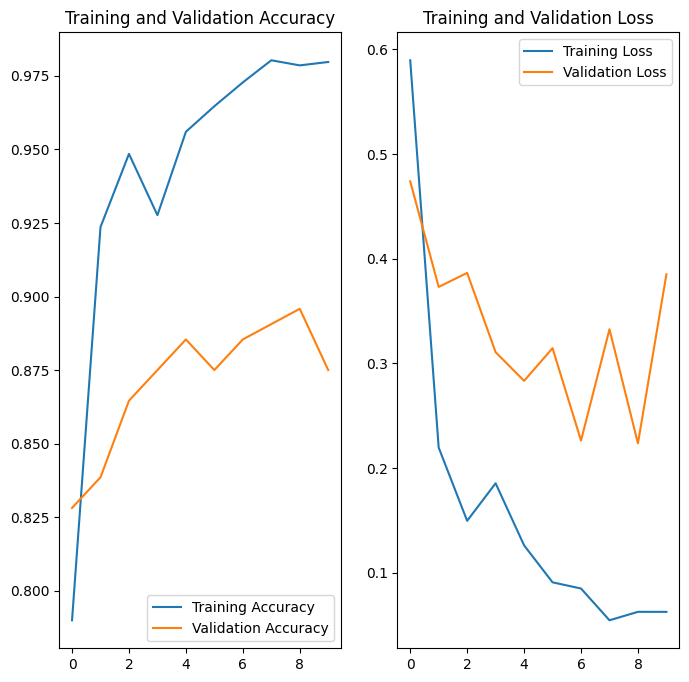

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label:  Potato___Early_blight
1/1 [==============================] - 5s 5s/step
predicted label: Potato___Early_blight


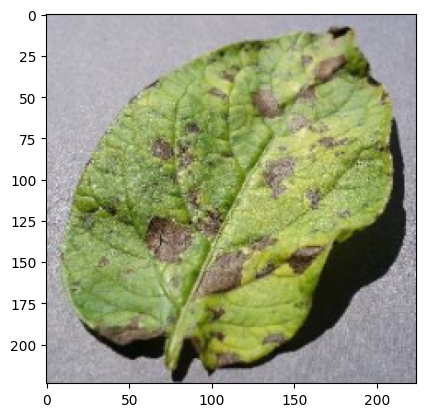

In [24]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)

    print("actual label: ",class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [25]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 189ms/step


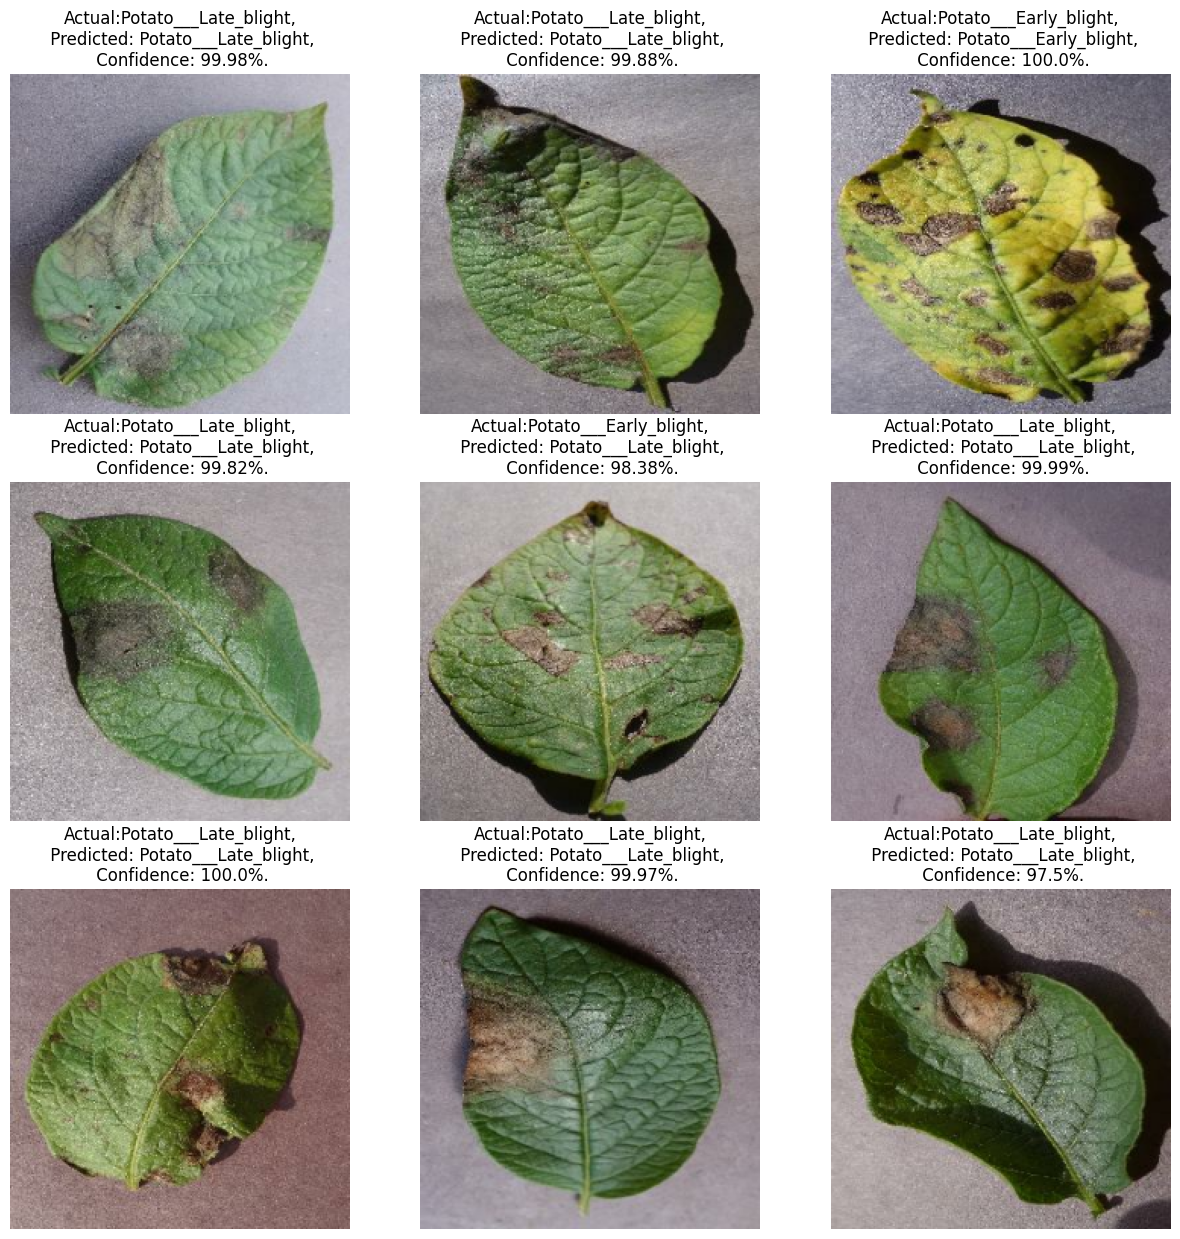

In [26]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%.")


        plt.axis("off")

In [27]:
import os
model_version=max([int(i) for i in os.listdir("models")+[0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/4/assets


INFO:tensorflow:Assets written to: models/4/assets
